In [8]:
import pandas as pd

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import seaborn as sns 

In [9]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 24,        # Larger axes/title fonts
        "legend.fontsize": 24,
    }
)
sns.set_context("talk")


In [10]:
palette_name = 'ocean_sunset'
palette = json.load(open(f'../palettes/{palette_name}.json', 'r'))

In [11]:
palette

{'Rich black': '#001219',
 'Midnight green': '#005f73',
 'Dark cyan': '#0a9396',
 'Tiffany Blue': '#94d2bd',
 'Vanilla': '#e9d8a6',
 'Gamboge': '#ee9b00',
 'Alloy orange': '#ca6702',
 'Rust': '#bb3e03',
 'Rufous': '#ae2012',
 'Auburn': '#9b2226'}

## Sequence length

In [3]:
model_names = ['gemma-3-1b-pt', 'gpt2']

for model in model_names:

    filename_fn = lambda x: f'{x}-layer-length-stats.csv'
    df = pd.read_csv(f'../data/seq_length_ablation/{filename_fn(model)}')

    print(df.head())

   layer  length     count          mean          std          min  \
0     26      20  49994963  12022.628010  2200.396388  1907.496094   
1     26      40  49994976  12724.423054  2360.091636   436.333496   
2     26      60  49994995  12974.092738  2501.040001  1031.077393   
3     26      80  49994998  13147.599481  2527.923922   398.565430   
4     26     100  49994999  13194.214511  2578.286006  1520.329346   

            max  
0  40160.304688  
1  44681.972656  
2  52858.804688  
3  50035.449219  
4  53408.054688  
   layer  length     count        mean         std       min          max
0     12      20  49994821  284.137408  112.659850  0.000420  1479.251465
1     12      40  49994984  308.696301  120.457262  0.000466  1394.722778
2     12      60  49994994  318.591916  122.864669  0.000746  1580.808838
3     12      80  49994995  328.647104  129.396979  4.878380  1597.845215
4     12     100  49994996  333.699054  131.351975  5.765115  1414.837280


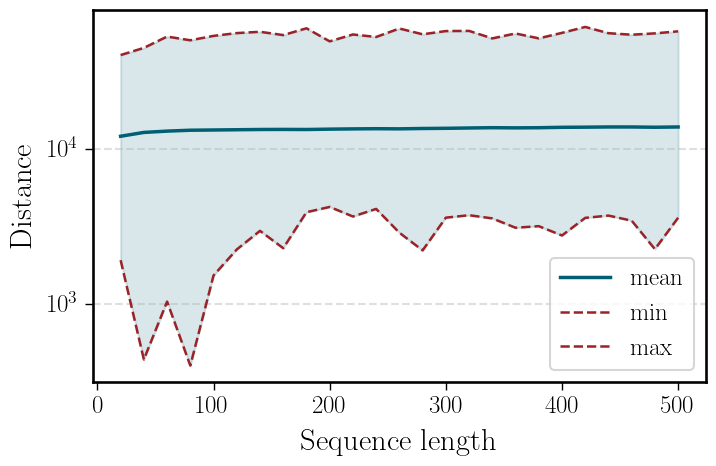

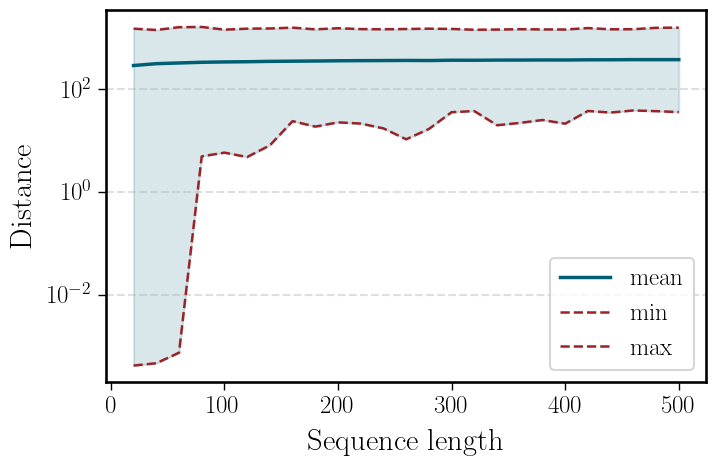

In [20]:


model_names = ['gemma-3-1b-pt', 'gpt2']

for model in model_names:
    filename_fn = lambda x: f'{x}-layer-length-stats.csv'
    df = pd.read_csv(f'../data/seq_length_ablation/{filename_fn(model)}')

    # Ensure numeric and collapse any duplicate 'length' rows (e.g., multiple layers)
    cols = ['length', 'min', 'mean', 'max']
    # Some CSVs might have capitalization differences; normalize:
    df = df.rename(columns={c: c.lower() for c in df.columns})
    needed = ['length', 'min', 'mean', 'max']
    if not set(needed).issubset(df.columns):
        missing = set(needed) - set(df.columns)
        raise ValueError(f"Missing columns in {model}: {missing}")

    # Make sure they're numeric
    for c in needed:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Aggregate in case multiple rows per length exist (e.g., different layers)
    agg = (
        df.groupby('length', as_index=False)[['min', 'mean', 'max']]
          .mean()
          .sort_values('length')
    )

    x = agg['length'].values
    y_min = agg['min'].values
    y_mean = agg['mean'].values
    y_max = agg['max'].values

    plt.figure(figsize=(7.5, 5))

    # shaded band
    plt.fill_between(x, y_min, y_max, color=palette['Midnight green'], alpha=0.15)

    # mean line
    plt.plot(x, y_mean, color=palette['Midnight green'], linewidth=2.5, label='mean')

    # optional dashed min/max lines
    plt.plot(x, y_min, linestyle="--", color=palette['Auburn'], linewidth=1.8, label='min')
    plt.plot(x, y_max, linestyle="--", color=palette['Auburn'], linewidth=1.8, label='max')

    plt.axhline(0.0, linestyle=":", color=palette['Auburn'], linewidth=1.5, alpha=0.8)

    plt.yscale('log')
    plt.xlabel('Sequence length', fontsize=22, labelpad=8)
    plt.ylabel('Distance', fontsize=22, labelpad=8)

    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tick_params(axis="x", labelsize=18, width=1.0, length=6)
    plt.tick_params(axis="y", labelsize=18, width=1.0, length=6)
    plt.tick_params(axis="y", which='minor', labelsize=18, width=0.0, length=6)

    plt.legend(frameon=True, framealpha=0.8, fontsize=18, loc="best")

    plt.tight_layout()
    plt.savefig(f'../figures/exhaustive_collisions/{model}-distances-vs-length.pdf', dpi=300, bbox_inches="tight")
    plt.show()
